/var/folders/wd/d0j10lq906x4lfc0bphzybd80000gn/T/ipykernel_55901/4146553181.py:10: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  medication = pd.read_csv("data/eicu/medication.csv")


Total patients using ventilator:  71098
Patients using ventilator after 48 hours:  18635
Patients using ventilator before 48 hours:  69184
Patients using ventilator before 48 hours:  52463


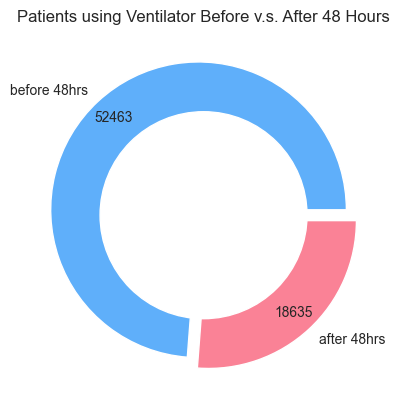

In [1]:
import pandas as pd
import fasttext
import numpy as np
from tqdm import tqdm
import re

import matplotlib.pyplot as plt

patient = pd.read_csv("data/eicu/patient.csv")
medication = pd.read_csv("data/eicu/medication.csv")

# Filter treatment after 48 hours
treatment = pd.read_csv("data/eicu/treatment.csv")

ventilator_all = treatment[treatment['treatmentstring'].str.contains('ventilation')]
ventilator_patients_all = ventilator_all['patientunitstayid'].unique()
print("Total patients using ventilator: ", len(ventilator_patients_all))

treatment_after_48 = treatment[treatment['treatmentoffset'] >= 48 * 60]
ventilator = treatment_after_48[treatment_after_48['treatmentstring'].str.contains('ventilation')]
ventilator_patients_after_48 = ventilator['patientunitstayid'].unique()
print("Patients using ventilator after 48 hours: ", len(ventilator_patients_after_48))

treatment_before_48 = treatment[treatment['treatmentoffset'] < 48 * 60]
ventilator = treatment_before_48[treatment_before_48['treatmentstring'].str.contains('ventilation')]
ventilator_patients_before_48 = ventilator['patientunitstayid'].unique()
print("Patients using ventilator before 48 hours: ", len(ventilator_patients_before_48))

ventilator_patients_before_48 = set(ventilator_patients_all) - set(ventilator_patients_after_48)
print("Patients using ventilator before 48 hours: ", len(ventilator_patients_before_48))

labels = ['before 48hrs', 'after 48hrs']
patients_count = [len(ventilator_patients_before_48), len(ventilator_patients_after_48)]

# colors
colors = ["#5faffa", "#fa8296"]

explode = (0.05, 0.05)

# Pie Chart
_, _, autotexts = plt.pie(patients_count, colors=colors, labels=labels,
                          autopct='%1.1f%%', pctdistance=0.85, explode=explode)

for i, a in enumerate(autotexts):
    a.set_text("{}".format(patients_count[i]))
 
# draw circle
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
 
# Adding Circle in Pie chart
fig.gca().add_artist(centre_circle)
 
# Adding Title of chart
plt.title('Patients using Ventilator Before v.s. After 48 Hours')

# Displaying Chart
plt.show()

In [2]:
patient.head()

,patientunitstayid,patienthealthsystemstayid,gender,age,ethnicity,hospitalid,wardid,apacheadmissiondx,admissionheight,hospitaladmittime24,...,unitadmitsource,unitvisitnumber,unitstaytype,admissionweight,dischargeweight,unitdischargetime24,unitdischargeoffset,unitdischargelocation,unitdischargestatus,uniquepid
0,141168,128919,Female,70,Caucasian,59,91,"Rhythm disturbance (atrial, supraventricular)",152.4,15:54:00,...,Direct Admit,1,admit,84.3,85.8,03:50:00,3596,Death,Expired,002-34851
1,141178,128927,Female,52,Caucasian,60,83,NaN,162.6,08:56:00,...,Emergency Department,1,admit,54.4,54.4,09:18:00,8,Step-Down Unit (SDU),Alive,002-33870
2,141179,128927,Female,52,Caucasian,60,83,NaN,162.6,08:56:00,...,ICU to SDU,2,stepdown/other,NaN,60.4,19:20:00,2042,Home,Alive,002-33870
3,141194,128941,Male,68,Caucasian,73,92,"Sepsis, renal/UTI (including bladder)",180.3,18:18:40,...,Floor,1,admit,73.9,76.7,15:31:00,4813,Floor,Alive,002-5276
4,141196,128943,Male,71,Caucasian,67,109,NaN,162.6,20:21:00,...,ICU to SDU,2,stepdown/other,NaN,63.2,22:23:00,1463,Floor,Alive,002-37665


/var/folders/wd/d0j10lq906x4lfc0bphzybd80000gn/T/ipykernel_55901/3459318328.py:6: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  medication = pd.read_csv("data/eicu/medication.csv")


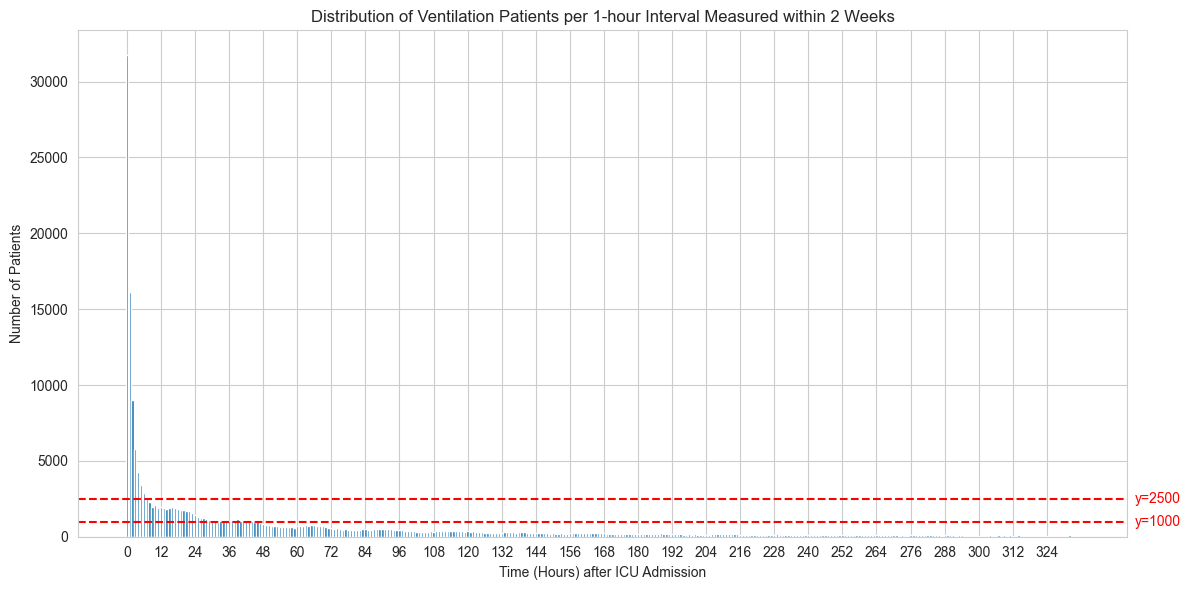

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

patient = pd.read_csv("data/eicu/patient.csv")
medication = pd.read_csv("data/eicu/medication.csv")
treatment = pd.read_csv("data/eicu/treatment.csv")

bin_hour = 1
total_observe_hour = 336
ventilator = treatment[treatment['treatmentstring'].str.contains('ventilation')]

def calculate_unique_patients_counts(ventilator, bin_hour):
    ventilator_cp = ventilator.copy(deep=True)
    ventilator_cp['bin'] = (ventilator['treatmentoffset'] // (bin_hour * 60)).astype(int)
    
    # Count unique patients within each bin
    unique_patient_counts = ventilator_cp.drop_duplicates(subset=['patientunitstayid', 'bin']).groupby('bin').size()
    return unique_patient_counts

bins = np.arange(0, total_observe_hour // bin_hour)
unique_patient_counts = calculate_unique_patients_counts(ventilator, bin_hour)
counts = unique_patient_counts.reindex(bins, fill_value=0).values

tick_values = [b for b in bins if b * bin_hour % 12 == 0]
tick_labels = [str(b * bin_hour) for b in tick_values]

plt.figure(figsize=(12, 6))
plt.bar(bins, counts)
plt.title(f'Distribution of Ventilation Patients per {bin_hour}-hour Interval Measured within 2 Weeks')
plt.xlabel(f'Time (Hours) after ICU Admission')
plt.ylabel('Number of Patients')
plt.xticks(tick_values, tick_labels)
plt.axhline(y=1000, color='r', linestyle='--', linewidth=1.5)
plt.axhline(y=2500, color='r', linestyle='--', linewidth=1.5)
plt.text(max(bins) + 20, 1000, 'y=1000', verticalalignment='center', color='r')
plt.text(max(bins) + 20, 2500, 'y=2500', verticalalignment='center', color='r')
plt.tight_layout()
plt.show()

In [4]:
patient = pd.read_csv("data/eicu/patient.csv")

In [5]:
(patient[(patient["hospitalid"] == 167) & (patient["unitdischargestatus"] == 'Expired')]).shape

(257, 29)

167 [0.21602101 0.06795798 0.054826   0.03791858 0.03332239 0.02626395]
420 [0.39559735 0.34002992 0.19213507 0.26458645 0.13464415 0.19363112]
199 [0.35825472 0.15188679 0.10589623 0.08254717 0.05919811 0.05165094]
458 [0.4020535  0.13699    0.09727101 0.08754391 0.06484734 0.06538773]
252 [0.39038861 0.13022842 0.08899436 0.07208543 0.05487986 0.04983684]
165 [0.21978382 0.0687848  0.04094333 0.03373731 0.02587619 0.02358336]
148 [0.27143353 0.07844498 0.05484207 0.03332176 0.03922249 0.02950364]
281 [0.3666535  0.06163572 0.04780719 0.04780719 0.03792967 0.02923746]
449 [0.68104265 0.27867299 0.19478673 0.16161137 0.10853081 0.10995261]
283 [0.38388174 0.07868383 0.05865522 0.04196471 0.03338102 0.02670482]


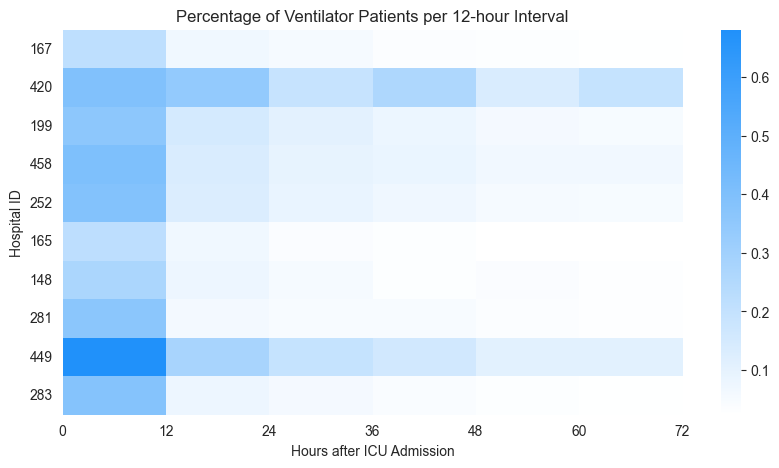

In [6]:
import matplotlib.colors as mcolors

bin_hour = 12
total_observe_hour = 72

counts_np = np.zeros((10, 6))

for idx, hospital_id in enumerate([167, 420, 199, 458, 252, 165, 148, 281, 449, 283]):
    
    patient_df = patient[patient["hospitalid"] == hospital_id]
    hospital_patients = patient_df["patientunitstayid"].unique()
    hospital_ventilator = ventilator[ventilator["patientunitstayid"].isin(hospital_patients)]
    
    bins = np.arange(0, total_observe_hour // bin_hour)
    unique_patient_counts = calculate_unique_patients_counts(hospital_ventilator, bin_hour)
    counts = unique_patient_counts.reindex(bins, fill_value=0).values / len(hospital_patients)
    
    print(hospital_id, counts)
    counts_np[idx] = counts

import seaborn as sns

y_tick_labels = ["167", "420", "199", "458", "252", "165", "148", "281", "449", "283"]
x_tick_labels = [0, 12, 24, 36, 48, 60, 72]

cmap = mcolors.LinearSegmentedColormap.from_list('custom_blue_white', ['white', '#2091fa'])

plt.figure(figsize=(10, 5))
plt.title(f'Percentage of Ventilator Patients per {bin_hour}-hour Interval')
sns.heatmap(counts_np, cmap=cmap)
plt.xlabel("Hours after ICU Admission")
plt.ylabel("Hospital ID")
plt.yticks(ticks=(np.arange(len(y_tick_labels)) + 0.5), labels=y_tick_labels, rotation=0)
plt.xticks(ticks=(np.arange(len(x_tick_labels))), labels=x_tick_labels, rotation=0)
plt.show()

In [7]:
def calculate_death_patients_counts(patient, bin_hour):
    patient_cp = patient.copy(deep=True)
    patient_cp['bin'] = (patient['unitdischargeoffset'] // (bin_hour * 60)).astype(int)
    
    # Count unique patients within each bin
    unique_patient_counts = patient_cp.drop_duplicates(subset=['patientunitstayid', 'bin']).groupby('bin').size()
    return unique_patient_counts

167 [0.00722259 0.00476034 0.00377544 0.00279054 0.00180565 0.00114905]
420 [0.01325069 0.00940372 0.00983116 0.00769395 0.00534302 0.00577046]
199 [0.0129717  0.00943396 0.00636792 0.00518868 0.00353774 0.00400943]
458 [0.01540124 0.0097271  0.00540394 0.00648473 0.00567414 0.00486355]
252 [0.01868882 0.01038268 0.01008603 0.0068229  0.00415307 0.00444972]
165 [0.01048149 0.0049132  0.00458565 0.00294792 0.00393056 0.00229283]
148 [0.00590073 0.00381812 0.00902464 0.00173551 0.00381812 0.00138841]
281 [0.01224812 0.00632161 0.00553141 0.00513631 0.0019755  0.0019755 ]
449 [0.01184834 0.00947867 0.00663507 0.00663507 0.007109   0.0042654 ]
283 [0.01335241 0.01382928 0.00524559 0.00429185 0.00286123 0.00476872]


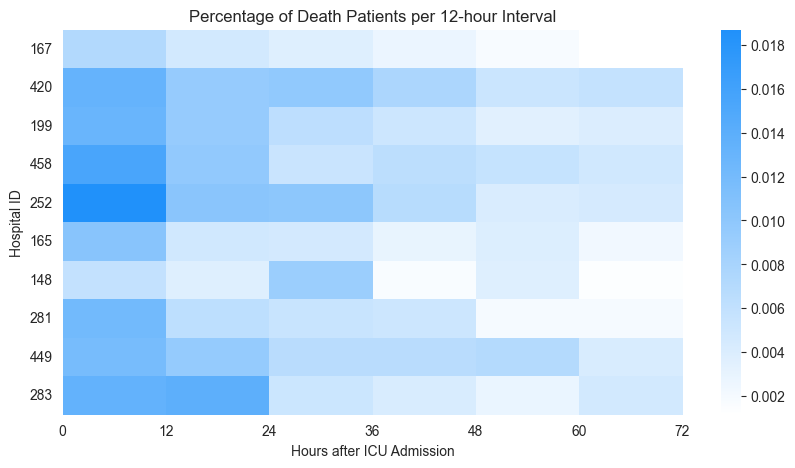

In [8]:
bin_hour = 12
total_observe_hour = 72

counts_np = np.zeros((10, 6))

for idx, hospital_id in enumerate([167, 420, 199, 458, 252, 165, 148, 281, 449, 283]):
    
    patient_df = patient[(patient["hospitalid"] == hospital_id)]
    hospital_patients = patient_df["patientunitstayid"].unique()
    hospital_death = patient_df[patient_df["unitdischargestatus"] == 'Expired']
    
    bins = np.arange(0, total_observe_hour // bin_hour)
    unique_patient_counts = calculate_death_patients_counts(hospital_death, bin_hour)
    
    counts = unique_patient_counts.reindex(bins, fill_value=0).values / len(hospital_patients)
    
    print(hospital_id, counts)
    counts_np[idx] = counts

import seaborn as sns

y_tick_labels = ["167", "420", "199", "458", "252", "165", "148", "281", "449", "283"]
x_tick_labels = [0, 12, 24, 36, 48, 60, 72]

plt.figure(figsize=(10, 5))
plt.title(f'Percentage of Death Patients per {bin_hour}-hour Interval')
sns.heatmap(counts_np, cmap=cmap)
plt.xlabel("Hours after ICU Admission")
plt.ylabel("Hospital ID")
plt.yticks(ticks=(np.arange(len(y_tick_labels)) + 0.5), labels=y_tick_labels, rotation=0)
plt.xticks(ticks=(np.arange(len(x_tick_labels))), labels=x_tick_labels, rotation=0)
plt.show()

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

diagnosis = pd.read_csv("data/eicu/diagnosis.csv")
sepsis = diagnosis[diagnosis['diagnosisstring'].str.contains('sepsis')]

def calculate_unique_sepsis_patients_counts(sepsis, bin_hour):
    sepsis_cp = sepsis.copy(deep=True)
    sepsis_cp['bin'] = (sepsis['diagnosisoffset'] // (bin_hour * 60)).astype(int)

    # Count unique patients within each bin
    unique_patient_counts = sepsis_cp.drop_duplicates(subset=['patientunitstayid', 'bin']).groupby('bin').size()
    return unique_patient_counts

167 [0.07944846 0.03168089 0.02166776 0.01657912 0.01460932 0.01017728]
420 [0.16819833 0.14426159 0.09019021 0.12566788 0.06689464 0.09638812]
199 [0.08349057 0.04245283 0.03325472 0.02995283 0.02028302 0.01816038]
458 [0.04782491 0.02296677 0.01810322 0.01864361 0.01161848 0.01378006]
252 [0.15692673 0.06822901 0.04865025 0.0415307  0.03322456 0.02877484]
165 [0.08188667 0.03144448 0.02194563 0.01867016 0.01539469 0.01375696]
148 [0.12044429 0.04547032 0.03505727 0.01874349 0.0201319  0.01318986]
281 [0.14105097 0.02331094 0.01580403 0.01185302 0.01224812 0.00908732]
449 [0.06777251 0.02985782 0.02180095 0.02180095 0.01327014 0.01327014]
283 [0.17835002 0.02241297 0.02813543 0.01669051 0.01144492 0.01001431]


/var/folders/wd/d0j10lq906x4lfc0bphzybd80000gn/T/ipykernel_55901/2000165538.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab20', len([167, 420, 199, 458, 252, 165, 148, 281, 449, 283]))


<Figure size 800x600 with 0 Axes>

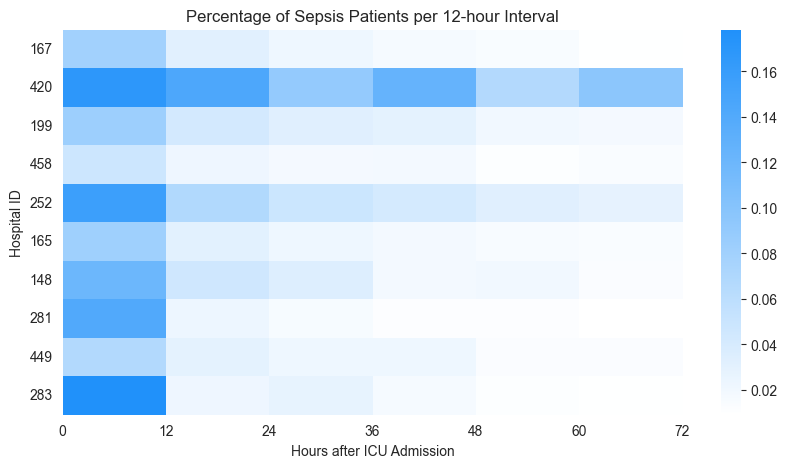

In [10]:
import matplotlib.ticker as mticker

plt.figure(figsize=(8, 6))

bin_hour = 12
total_observe_hour = 72

counts_np = np.zeros((10, 6))

color_map = plt.cm.get_cmap('tab20', len([167, 420, 199, 458, 252, 165, 148, 281, 449, 283]))

for idx, hospital_id in enumerate([167, 420, 199, 458, 252, 165, 148, 281, 449, 283]):
    patient_df = patient[patient["hospitalid"] == hospital_id]
    hospital_patients = patient_df["patientunitstayid"].unique()
    hospital_sepsis = sepsis[sepsis["patientunitstayid"].isin(hospital_patients)]

    bins = np.arange(0, total_observe_hour // bin_hour)
    unique_patient_counts = calculate_unique_sepsis_patients_counts(hospital_sepsis, bin_hour)
    counts = unique_patient_counts.reindex(bins, fill_value=0).values / len(hospital_patients)
    
    print(hospital_id, counts)
    counts_np[idx] = counts

import seaborn as sns

y_tick_labels = ["167", "420", "199", "458", "252", "165", "148", "281", "449", "283"]
x_tick_labels = [0, 12, 24, 36, 48, 60, 72]

plt.figure(figsize=(10, 5))
plt.title(f'Percentage of Sepsis Patients per {bin_hour}-hour Interval')
sns.heatmap(counts_np, cmap=cmap)
plt.xlabel("Hours after ICU Admission")
plt.ylabel("Hospital ID")
plt.yticks(ticks=(np.arange(len(y_tick_labels)) + 0.5), labels=y_tick_labels, rotation=0)
plt.xticks(ticks=(np.arange(len(x_tick_labels))), labels=x_tick_labels, rotation=0)
plt.show()

In [11]:
for idx, hospital_id in enumerate([167, 420, 199, 458, 252, 165, 148, 281, 449, 283]):
    
    patient_df = patient[patient["hospitalid"] == hospital_id]
    hospital_patients = patient_df["patientunitstayid"].unique()
    print(hospital_id, len(hospital_patients))

167 6092
420 4679
199 4240
458 3701
252 3371
165 3053
148 2881
281 2531
449 2110
283 2097


In [12]:
import pandas as pd
import fasttext
import numpy as np
from tqdm import tqdm
import re

unique_drugs = ['acetamin', 'biotene', 'compazine', 'ferrous', 'imdur', 'lidocaine', 'milk of magnesia', 'nystatin', 'prochlorperazine', 'tamsulosin',
                'advair diskus', 'bisacodyl', 'coreg', 'flagyl', 'influenza vac', 'lipitor', 'mineral', 'omeprazole', 'promethazine', 'thiamine',
                'albumin', 'bumetanide', 'cozaar', 'flomax', 'infuvite', 'lisinopril', 'mineral oil', 'ondansetron', 'propofol', 'ticagrelor',
                'albuterol', 'bumex', 'decadron', 'flumazenil', 'insulin', 'lispro', 'mono-sod', 'optiray', 'pulmicort respule', 'tiotropium',
                'allopurinol', 'buminate', 'definity', 'fluticasone-salmeterol', 'insulin detemir', 'loratadine', 'morphine', 'oxycodone', 'quetiapine', 'toradol',
                'alprazolam', 'calcium carbonate', 'deltasone', 'folic acid', 'iohexol', 'lorazepam', 'motrin', 'pantoprazole', 'refresh p.m. op oint', 'tramadol',
                'alteplase', 'calcium chloride', 'dexamethasone', 'furosemide', 'iopamidol', 'losartan', 'mupirocin', 'parenteral nutrition', 'reglan', 'trandate',
                'alum hydroxide', 'calcium gluconate', 'dexmedetomidine', 'gabapentin', 'ipratropium', 'maalox', 'nafcillin', 'percocet', 'restoril', 'transde rm-scop',
                'ambien', 'cardizem', 'dextrose', 'glargine', 'isosorbide', 'magnesium chloride', 'naloxone', 'phenergan', 'ringers solution', 'trazodone',
                'aminocaproic acid', 'carvedilol', 'diazepam', 'glucagen', 'kayciel', 'magnesium hydroxide', 'narcan', 'phenylephrine', 'rocuronium', 'ultram',
                'amiodarone', 'catapres', 'digoxin', 'glucagon', 'kayexalate', 'magnesium oxide', 'neostigmine', 'phytonadione', 'roxicodone', 'valium',
                'amlodipine', 'cefazolin', 'diltiazem', 'glucose', 'keppra', 'magnesium sulf', 'neostigmine methylsulfate', 'piperacillin', 'sennosides', 'vancomycin',
                'anticoagulant', 'cefepime', 'diphenhydramine', 'glycopyrrolate', 'ketorolac', 'magox', 'neurontin', 'plasmalyte', 'seroquel', 'vasopressin',
                'apresoline', 'ceftriaxone', 'diprivan', 'guaifenesin', 'klonopin', 'medrol', 'nexterone', 'plavix', 'sertraline', 'ventolin',
                'ascorbic acid', 'cephulac', 'docusate', 'haldol', 'labetalol', 'meperidine', 'nicardipine', 'pneumococcal', 'simethicone', 'vitamin',
                'aspart', 'cetirizine', 'dopamine', 'haloperidol', 'lactated ringer', 'meropenem', 'nicoderm', 'pnu-immune-23', 'simvastatin', 'warfarin',
                'aspirin', 'chlorhexidine', 'ecotrin', 'heparin', 'lactulose', 'merrem', 'nicotine', 'polyethylene glycol', 'sodium bicarbonate', 'xanax',
                'atenolol', 'ciprofloxacin', 'enoxaparin', 'humulin', 'lanoxin', 'metformin', 'nitro-bid', 'potassium chloride', 'sodium chloride', 'zestril',
                'atorvastatin', 'cisatracurium', 'ephedrine', 'hydralazine', 'lantus', 'methylprednisolone', 'nitroglycerin', 'potassium phosphate', 'sodium phosphate', 'zocor',
                'atropine', 'citalopram', 'epinephrine', 'hydrochlorothiazide', 'levaquin', 'metoclopramide', 'nitroprusside', 'pravastatin', 'polystyrene sulfonate', 'zolpidem',
                'atrovent', 'clindamycin', 'etomidate', 'hydrocodone', 'levemir', 'metoprolol', 'norco', 'precedex', 'spironolactone', 'zosyn',
                'azithromycin', 'clonazepam', 'famotidine', 'hydrocortisone', 'levetiracetam', 'metronidazole', 'norepinephrine', 'prednisone', 'sublimaze',
                'bacitracin', 'clonidine', 'fat emulsion', 'hydromorphone', 'levofloxacin', 'midazolam', 'normodyne', 'prilocaine', 'succinylcholine',
                'bayer chewable', 'clopidogrel', 'fentanyl', 'ibuprofen', 'levothyroxine', 'midodrine', 'norvasc', 'prinivil', 'tacrolimus']


def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))


def calculate_similarity(model, drug1, drug2):
    drug1_vector = model.get_word_vector(drug1)
    drug2_vector = model.get_word_vector(drug2)
    return cosine_similarity(drug1_vector, drug2_vector)

def harmonize_drug(drug, unique_drugs, pretrained):

    if pd.isna(drug):
        return None

    drug = drug.lower()

    # Direct mapping: check whether drug names contain unique_drug
    for unique_drug in unique_drugs:
        if unique_drug in drug:
            return unique_drug

    # Check cosine similarity between word embeddings
    converted = re.sub(r'[^a-zA-Z\s]', '', drug)
    best_similarity = float('-inf')
    best_drug = None
    for drug_name in converted.split():
        for unique_drug in unique_drugs:
            similarity = calculate_similarity(
                pretrained, drug_name, unique_drug)
            if similarity > best_similarity:
                best_similarity = similarity
                best_drug = unique_drug

    return best_drug

In [13]:
medication_imputed = pd.read_csv("output/medication_imputed.csv")
patient_medication = patient.merge(medication_imputed, on='patientunitstayid', how='inner')
patient_medication = patient_medication[patient_medication["hospitalid"].isin([167, 420, 199, 458, 252, 165, 148, 281, 449, 283])]
patient_medication.head()

/var/folders/wd/d0j10lq906x4lfc0bphzybd80000gn/T/ipykernel_55901/3857972053.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  medication_imputed = pd.read_csv("output/medication_imputed.csv")


,patientunitstayid,patienthealthsystemstayid,gender,age,ethnicity,hospitalid,wardid,apacheadmissiondx,admissionheight,hospitaladmittime24,...,drugordercancelled,drugname,drughiclseqno,dosage,routeadmin,frequency,loadingdose,prn,drugstopoffset,gtc
1240048,534589,451226,Male,86,Caucasian,165,337,NaN,178.0,18:40:00,...,No,HYDRALAZINE HCL 25 MG PO TABS,89.0,75 mg,PO,QID,NaN,No,9408,41
1240049,534589,451226,Male,86,Caucasian,165,337,NaN,178.0,18:40:00,...,No,HYDRALAZINE HCL 25 MG PO TABS,89.0,50 mg,PO,QID,NaN,No,8720,41
1240050,534589,451226,Male,86,Caucasian,165,337,NaN,178.0,18:40:00,...,No,NaN,3682.0,30 mL,PO,DAILY,NaN,No,9408,59
1240051,534589,451226,Male,86,Caucasian,165,337,NaN,178.0,18:40:00,...,No,HYDRALAZINE HCL 25 MG PO TABS,89.0,50 mg,PO,Q8H,NaN,No,7440,41
1240052,534589,451226,Male,86,Caucasian,165,337,NaN,178.0,18:40:00,...,No,amLODIPine 5 MG TAB,6494.0,10 mg,PO,DAILY,NaN,No,9408,38


In [ ]:
pretrained = fasttext.load_model("data/pretrained/BioWordVec_PubMed_MIMICIII_d200.bin")

In [ ]:
# # TODO: deep copy patient_medication
# # TODO: add column "harmonized_drug"
# 
# for idx, hospital_id in enumerate([167, 420, 199, 458, 252, 165, 148, 281, 449, 283]):
#     
#     hospital_patient_medication = patient_medication[patient_medication["hospitalid"] == hospital_id]
#     unique_patients = hospital_patient_medication["patientunitstayid"].unique()
#     
#     for unique_patient in unique_patients:
#         
#         patient_medication_data = hospital_patient_medication[hospital_patient_medication["patientunitstayid"] == unique_patient]
#         patient_drugs = patient_medication_data["drugname"]
#         for drug in patient_drugs:
#             harmonized_drug = harmonize_drug(drug, unique_drugs, pretrained)
#             # TODO: Add to "harmonized_drug" corresponding to the "drugname"

In [ ]:
patient_medication.shape

In [ ]:
deep_copied_patient_medication = patient_medication.copy(deep=True)
deep_copied_patient_medication["harmonized_drug"] = None
deep_copied_patient_medication["harmonized_drug"] = deep_copied_patient_medication["drugname"].apply(lambda drug: harmonize_drug(drug, unique_drugs, pretrained))

In [ ]:
deep_copied_patient_medication.head()

In [ ]:
deep_copied_patient_medication.columns

In [ ]:
bin_hour = 1
total_observe_hour = 24
bins = list(range(0, total_observe_hour + bin_hour, bin_hour)) # [0, 24, 48, ..., 168]
labels = list(range(len(bins)-1)) # [0, 1, 2, ..., 6]

for hospital_id in [167, 420, 199, 458, 252, 165, 148, 281, 449, 283]:
    mask = deep_copied_patient_medication["hospitalid"] == hospital_id
    deep_copied_patient_medication.loc[mask, 'binned_hours'] = pd.cut(deep_copied_patient_medication.loc[mask, 'drugstartoffset'] / 60, bins=bins, labels=labels)

In [ ]:
result = np.zeros((10, len(bins)-1))
for id, hospital_id in enumerate([167, 420, 199, 458, 252, 165, 148, 281, 449, 283]):
    hospital_data = deep_copied_patient_medication[deep_copied_patient_medication["hospitalid"] == hospital_id]
    grouped = hospital_data.groupby(['patientunitstayid', 'binned_hours'])
    unique_drugs_per_bin = grouped['harmonized_drug'].nunique()
    average_unique_drugs_per_bin = unique_drugs_per_bin.groupby('binned_hours').mean()
    result[id] = average_unique_drugs_per_bin

In [ ]:
result.shape

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_result = pd.DataFrame(result)
df_result.columns = [str(int(col) + 1) for col in df_result.columns]

# Plot heatmap
plt.figure(figsize=(15, 6))
sns.heatmap(df_result, cmap="Blues", annot=True, fmt=".3f", linewidths=.5)
plt.title("Average Number of Drugs Taken by Patents in Each Hospital")
plt.ylabel("Hospital ID")
plt.xlabel("Hour")
plt.yticks(ticks=[i+0.5 for i in range(df_result.shape[0])], labels=[167, 420, 199, 458, 252, 165, 148, 281, 449, 283])
plt.show()

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame from the given data
data = {
    'Hospital Id': [167, 420, 199, 458, 252, 165, 148, 281, 449, 283],
    'Day 1': [518, 906, 395, 185, 569, 271, 366, 372, 153, 380],
    'Day 2': [191, 807, 215, 111, 256, 102, 130, 64, 78, 88],
    'Day 3': [121, 636, 138, 82, 177, 69, 80, 52, 46, 43],
    'Day 4': [108, 489, 91, 51, 119, 40, 60, 35, 29, 27],
    'Day 5': [88, 388, 63, 54, 86, 32, 63, 25, 32, 16],
    'Day 6': [55, 335, 41, 50, 60, 22, 41, 14, 20, 12],
    'Day 7': [53, 282, 39, 36, 55, 19, 32, 11, 20, 13]
}

df = pd.DataFrame(data)

# Set Hospital Id as the index for better visualization
df = df.set_index('Hospital Id')

# Drop the 'Total Patients' column as we want to focus on daily numbers for the heatmap
# df = df.drop(columns=['Total Patients'])

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df, cmap='Greens', annot=True, fmt='g')
plt.title('Number of Patients Diagnosed with Sepsis per Day by Hospital ID')
plt.show()

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Data
data = {
    'Hospital Id': [167, 420, 199, 458, 252, 165, 148, 281, 449, 283],
    'Day 1': [0.085, 0.194, 0.093, 0.050, 0.169, 0.089, 0.127, 0.147, 0.073, 0.181],
    'Day 2': [0.031, 0.172, 0.051, 0.030, 0.076, 0.033, 0.045, 0.025, 0.037, 0.042],
    'Day 3': [0.020, 0.136, 0.033, 0.022, 0.053, 0.023, 0.028, 0.021, 0.022, 0.021],
    'Day 4': [0.018, 0.105, 0.021, 0.014, 0.035, 0.013, 0.021, 0.014, 0.014, 0.013],
    'Day 5': [0.014, 0.083, 0.015, 0.015, 0.026, 0.010, 0.022, 0.010, 0.015, 0.008],
    'Day 6': [0.009, 0.072, 0.010, 0.014, 0.018, 0.007, 0.014, 0.006, 0.009, 0.006],
    'Day 7': [0.009, 0.060, 0.009, 0.010, 0.016, 0.006, 0.011, 0.004, 0.009, 0.006]
}

df = pd.DataFrame(data)

# Drop non-relevant columns for the heatmap and convert to percentage
heatmap_data = df.drop(columns=['Hospital Id'])

# Create custom format for annotations
def fmt(x):
    return '{:.0f}%'.format(x)

# Plot
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='Greens', yticklabels=df['Hospital Id'], fmt='.1%')
plt.title('Percentage of Patients Diagnosed with Sepsis per Day by Hospital ID')
plt.ylabel('Hospital Id')
plt.show()


In [ ]:
lab = pd.read_csv("data/eicu/lab.csv")

In [ ]:
print([x for x in list(lab["labname"].unique())])

In [ ]:
custom_lab = pd.read_csv("data/eicu/customLab.csv")

In [ ]:
custom_lab.head()

In [ ]:
print([x for x in list(custom_lab["labothername"].unique())])

In [ ]:
admission_drug = pd.read_csv("data/eicu/admissionDrug.csv")
admission_drug.head()

In [ ]:
patient_medication = patient.merge(admission_drug, on='patientunitstayid', how='inner')
patient_medication = patient_medication[patient_medication["hospitalid"].isin([167, 420, 199, 458, 252, 165, 148, 281, 449, 283])]
patient_medication.head()

In [ ]:
import matplotlib.pyplot as plt

medication_not_nan_percentage = []
medication_nan_percentage = []
for hospitalid in pd.unique(patient_medication['hospitalid']).tolist():
    patient_medication_hospital = patient_medication[patient_medication['hospitalid'] == hospitalid]
    percentage = patient_medication_hospital[patient_medication_hospital['drugname'].isna()].shape[0] / patient_medication_hospital.shape[0]
    medication_not_nan_percentage.append(1 - percentage)
    medication_nan_percentage.append(percentage)

plt.figure(figsize=(8, 6))
plt.title("Percentage Distribution of Admission Drug Existance Across Hospitals")
plt.bar(np.arange(len(medication_nan_percentage)), medication_not_nan_percentage, label='Exist', color="#5faffa")
plt.bar(np.arange(len(medication_nan_percentage)), medication_nan_percentage, label='Not Exist', color="#fa8296", bottom=medication_not_nan_percentage)
plt.xticks([])
plt.xlabel("Hospitals")
plt.ylabel("Percentage")
plt.legend(title="Drug Name", loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Grouping by both hospitalid and patientunitstayid to compute the unique drugs for each patient in each hospital
grouped_medication = patient_medication.groupby(["hospitalid", "patientunitstayid"])["drugname"].unique()

hospital_ids = [167, 420, 199, 458, 252, 165, 148, 281, 449, 283]
means = []
std_devs = []

for hospital_id in hospital_ids:

    hospital_grouped_medication = grouped_medication.loc[hospital_id] if hospital_id in grouped_medication.index else []

    patient_drug_counts = []

    for patient_drugs in hospital_grouped_medication:
        harmonized_drugs = {harmonize_drug(drug, unique_drugs, pretrained) for drug in patient_drugs}
        patient_drug_counts.append(len(harmonized_drugs) / len(unique_drugs))
    
    mean_value = np.mean(patient_drug_counts) if len(patient_drug_counts) > 0 else 0
    std_value = np.std(patient_drug_counts) if len(patient_drug_counts) > 0 else 0
    
    means.append(mean_value)
    std_devs.append(std_value)

    print(f'hospital_id: {hospital_id}, mean: {mean_value}, std: {std_value}')

In [ ]:
from matplotlib.ticker import PercentFormatter
plt.bar(np.arange(len(hospital_ids)), means, yerr=std_devs, color="#5faffa", capsize=5)
plt.xticks(np.arange(len(hospital_ids)), hospital_ids)
plt.xlabel('Hospital ID')
plt.ylabel('Drug Taken Percentage')
plt.title('Admission Drug Taken Percentage for Different Hospitals')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

In [ ]:
percentage_patients = []
for idx, hospital_id in enumerate([167, 420, 199, 458, 252, 165, 148, 281, 449, 283]):

    hospital_patient_medication = patient_medication[patient_medication["hospitalid"] == hospital_id]
    unique_patients = hospital_patient_medication["patientunitstayid"].unique()

    patients_count = 0
    for idx, unique_patient in enumerate(unique_patients):

        patient_medication_data = hospital_patient_medication[hospital_patient_medication["patientunitstayid"] == unique_patient]
        patient_drugs = patient_medication_data["drugname"]
        if len(patient_drugs) > 0:
            patients_count += 1

    percentage = patients_count / len(unique_patients) if len(unique_patients) > 0 else 0
    percentage_patients.append(percentage)
    print("hospital_id: ", hospital_id, percentage)

In [ ]:
plt.bar(np.arange(len(hospital_ids)), percentage_patients,color="#5faffa", capsize=5)
plt.xticks(np.arange(len(hospital_ids)), hospital_ids)
plt.xlabel('Hospital ID')
plt.ylabel('Percentage')
plt.title('Patients Took Admission Drug / Total Patients Count in Each Hospital')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()